In [9]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 전역 설정
from matplotlib import rc
import os
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.size"] = 15

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [10]:
# 경로 설정
data_path = '../../data'
saved_path = './saved'
output_path = './submission'

![image](https://user-images.githubusercontent.com/86936634/200260871-256557e2-a70d-4499-8359-4ce056e06e97.png)

In [11]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
# history_df['profile_id'] = history_df['profile_id'].astype(str)
watch_e_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
# watch_e_df['profile_id'] = watch_e_df['profile_id'].astype(str)
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
search_df  = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')

meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), encoding='utf-8')

In [12]:
history_df = history_df.drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).reset_index(drop = True)
# print('같은 시간 중복 시청 전처리 전 후:',len(history_meta_profile_df),len(history_meta_profile_duplicate_df))
watch_e_df = watch_e_df.drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).reset_index(drop = True)

# 1.시청 시작 데이터 (history_data)

In [13]:
print('데이터 개수:',len(history_df))

데이터 개수: 899252


In [14]:
start_profile_cnt = history_df.profile_id.nunique()
start_album_cnt = history_df.album_id.nunique()

print('시청 시작 유저 수 :',start_profile_cnt, '시청 시작 아이템 수 :',start_album_cnt)

시청 시작 유저 수 : 8311 시청 시작 아이템 수 : 20695


In [15]:
# 유저 컨텐츠 시청 통계
pd.DataFrame(history_df.profile_id.value_counts().describe())

,profile_id
count,8311.000000
mean,108.200217
std,261.375965
min,1.000000
25%,10.000000
50%,36.000000
75%,101.000000
max,8264.000000


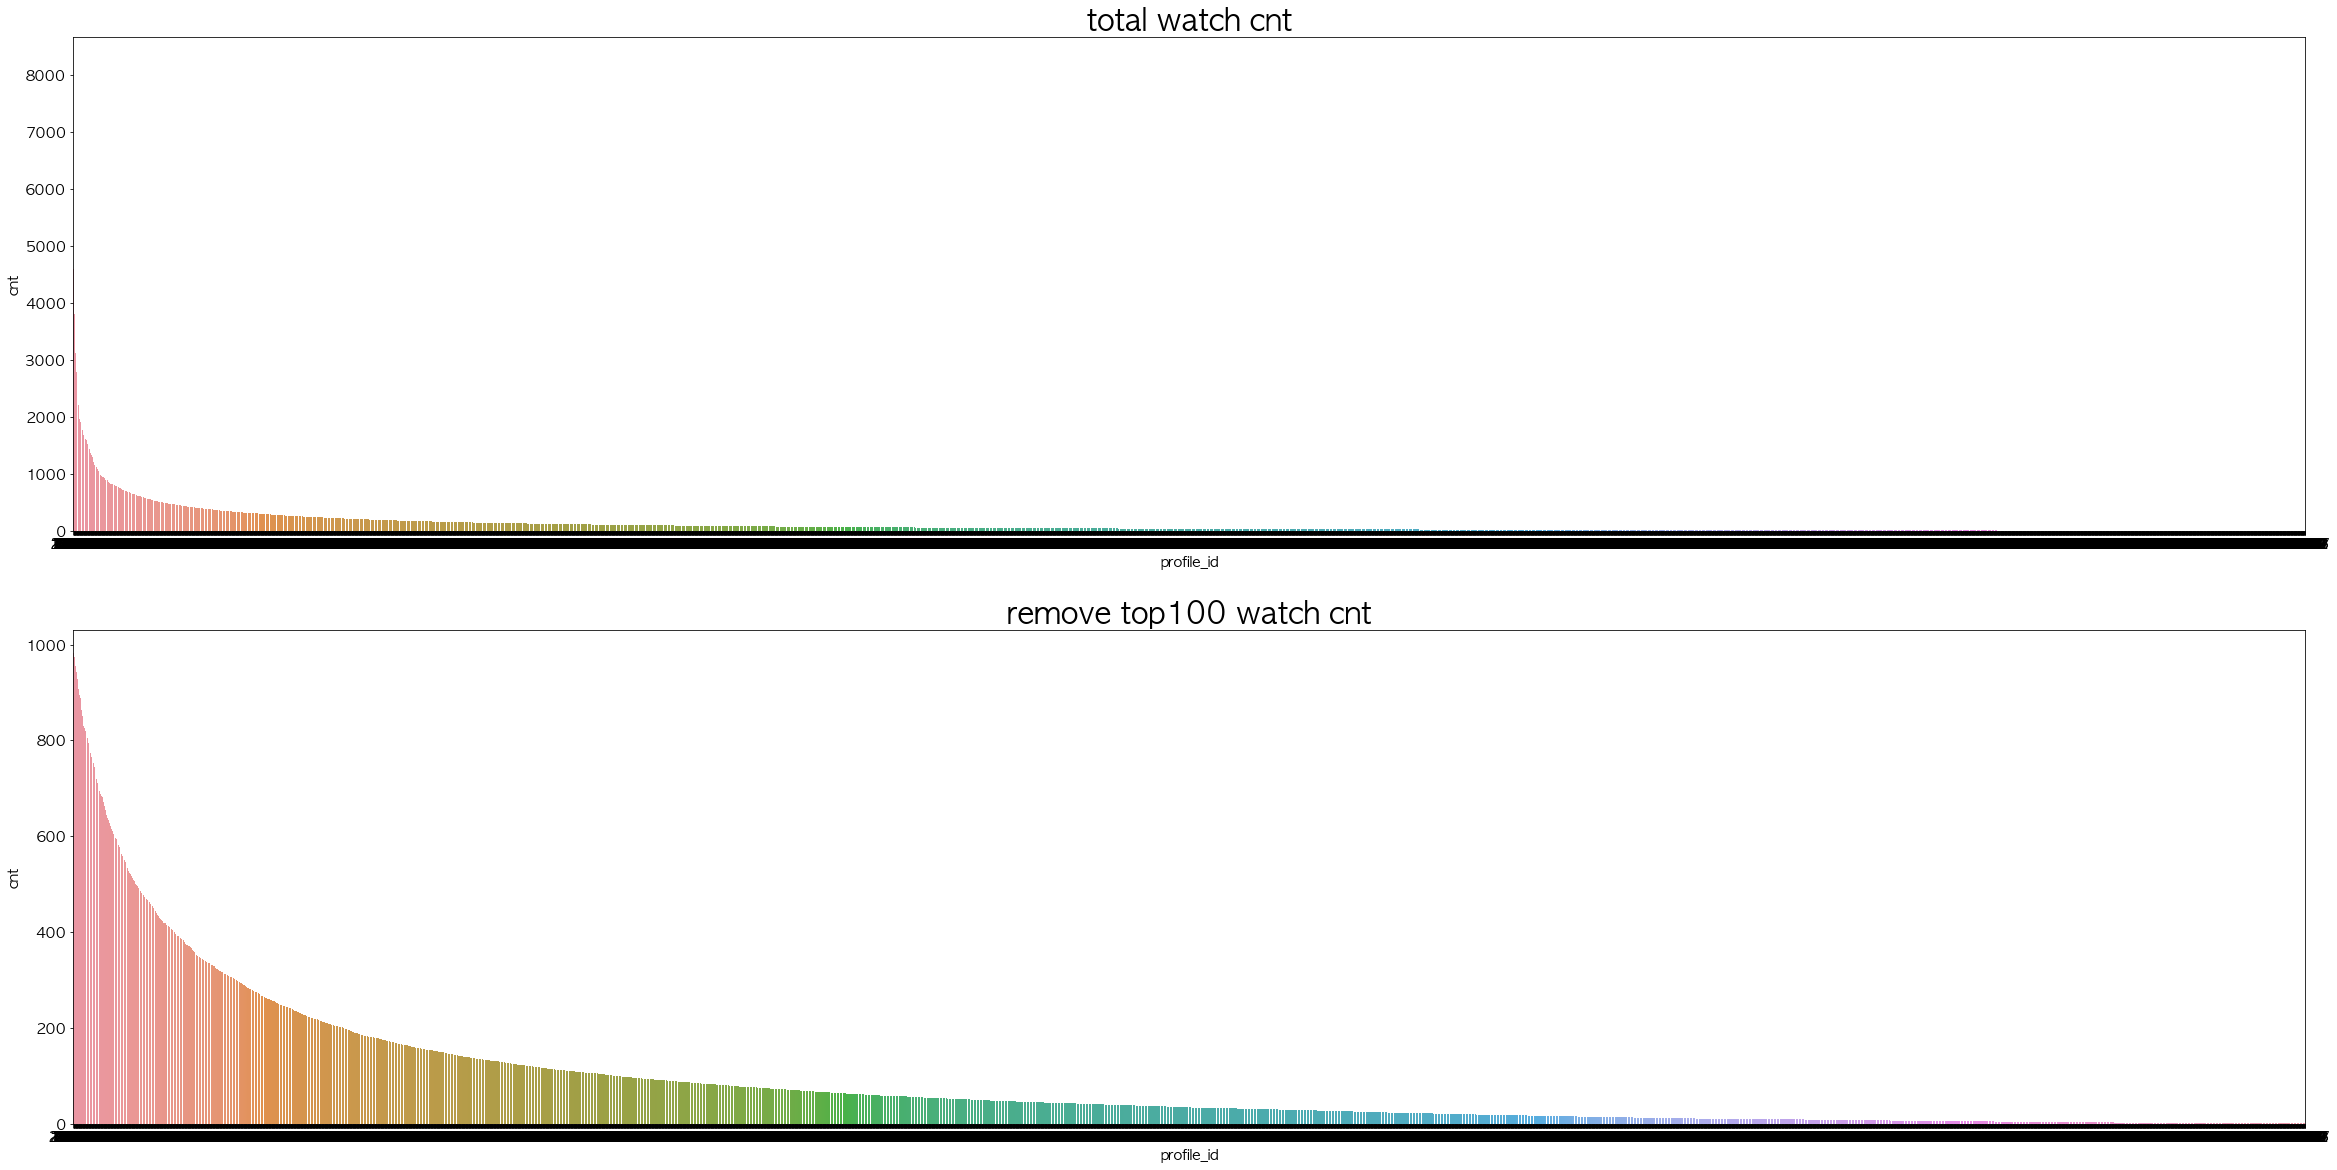

In [16]:
# top 100 제외하고도 longtail 문제가 심각
plt.figure(figsize=(40,20))
plt.subplot(211)
see_cnt_df = history_df.profile_id.value_counts().reset_index().rename(columns={'index':'profile_id','profile_id':'cnt'})
see_cnt_df['profile_id'] = see_cnt_df['profile_id'].astype(str)
plt.title('total watch cnt', fontsize=30)
sns.barplot(data = see_cnt_df, x='profile_id', y='cnt')
plt.subplot(212)
plt.title('remove top100 watch cnt', fontsize=30)
sns.barplot(data = see_cnt_df.iloc[100:,:], x='profile_id', y='cnt')
plt.show()

# 2.시청 종료 데이터(watch_e_data)

In [17]:
print('데이터 개수:',len(watch_e_df))

데이터 개수: 800632


In [18]:
end_profile_cnt = watch_e_df.profile_id.nunique()
end_album_cnt = watch_e_df.album_id.nunique()

print('시청 종료 유저 수 :',end_profile_cnt, '시청 종료 아이템 수 :',end_album_cnt)

시청 종료 유저 수 : 7658 시청 종료 아이템 수 : 20361


# 시작 종료 비교

### 시청 시작 종료 서로 다른 Log 개수 확인

In [19]:
# merge 는 profile_id , ss_id, album_id 기준으로 이루어질 수 있으니 이를 통해 서로만 있는 log 확인해보자

history_series_list = []
for (profile_id,ss_id,album_id) in zip(list(history_df.profile_id), list(history_df.ss_id), list(history_df.album_id)):
    history_series_list.append((profile_id, ss_id, album_id))
    
watch_e_series_list = []
for (profile_id,ss_id,album_id) in zip(list(watch_e_df.profile_id), list(watch_e_df.ss_id), list(watch_e_df.album_id)):
    watch_e_series_list.append((profile_id, ss_id, album_id))
    
print('시청 시작 데이터만 있는 log 개수:',len(set(history_series_list) - set(watch_e_series_list)))
print('시청 종료 데이터만 있는 log 개수:',len(set(watch_e_series_list) - set(history_series_list)))

시청 시작 데이터만 있는 log 개수: 83801
시청 종료 데이터만 있는 log 개수: 4986


In [20]:
# 진짜 서로 없는 지 확인 및 어떤 게 없는 지 확인
profile_list = []
ss_list = []
album_list = []
for (profile, ss, album) in set(watch_e_series_list) - set(history_series_list):
    profile_list.append(profile)
    ss_list.append(ss)
    album_list.append(album)

In [21]:
watch_e_unique_list = []
for (profile, ss, album) in set(watch_e_series_list) - set(history_series_list):
    watch_e_unique_list.append(watch_e_df[(watch_e_df['profile_id']==profile) &(watch_e_df['ss_id']==ss) &(watch_e_df['album_id']==album)])
    
history_unique_list = []
for (profile, ss, album) in set(watch_e_series_list) - set(history_series_list):
    history_unique_list.append(history_df[(history_df['profile_id']==profile) &(history_df['ss_id']==ss) &(history_df['album_id']==album)])    

In [22]:
history_del_ss_unique_list = []
for (profile, ss, album) in set(watch_e_series_list) - set(history_series_list):
    history_del_ss_unique_list.append(history_df[(history_df['profile_id']==profile)&(history_df['album_id']==album)])    

In [23]:
# 진짜 없음
watch_e_unique_df = pd.concat(watch_e_unique_list)
history_unique_df = pd.concat(history_unique_list)
history_del_ss_unique_df = pd.concat(history_del_ss_unique_list)
display(watch_e_unique_df)
display(history_unique_df)
# display(history_del_ss_unique_df)

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
156018,4466,20220319113366,20220319114755,MKID049,274,56,56,1
621732,21323,20220318072612,20220318074130,MKID049,3608,422,422,1
156061,4466,20220324174587,20220325065452,MKID049,9178,405,405,1
666623,23267,20220315185121,20220315190204,MKID049,2889,524,525,1
666624,23267,20220315185121,20220315190256,MKID049,2889,0,491,0
...,...,...,...,...,...,...,...,...
537656,17868,20220409072342,20220416160258,MKID049,1980,124,124,1
392849,12142,20220304091379,20220304092382,MKID049,5236,75,75,1
178097,5221,20220312162901,20220312163050,MKID049,265,32,96,0
467464,15164,20220423150396,20220423151234,MKID049,4078,573,586,0


,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer


### 시청 시작 종료 album_id 개수 차이 확인

In [24]:
print('시청 시작만 있는 앨범 수:',len(set(history_df.album_id) - set(watch_e_df.album_id)))
print('시청 종료만 있는 앨범 수:',len(set(watch_e_df.album_id) - set(history_df.album_id)))

시청 시작만 있는 앨범 수: 365
시청 종료만 있는 앨범 수: 31


### 시청 시작 종료 유저 수 차이 확인

In [25]:
print('시청 시작만 있는 유저 수:',len(set(history_df.profile_id) - set(watch_e_df.profile_id)))
print('시청 종료만 있는 유저 수:',len(set(watch_e_df.profile_id) - set(history_df.profile_id)))

시청 시작만 있는 유저 수: 653
시청 종료만 있는 유저 수: 0


###  유저별로 경향 살펴 보기 

In [26]:
# ss_id 처음 영상 시청시작 시간이고 log time은 각각 시작 종료 시간임 이 시간으로 watch_itme 계산됨
display(history_df[(history_df['profile_id']==3)&(history_df['album_id']==20)])
display(watch_e_df[(watch_e_df['profile_id']==3) & (watch_e_df['album_id']==20)])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
5,3,20220301115653,20220301120450,MKID003,20,NaN,Y,N
18,3,20220301115653,20220301123156,MKID003,20,NaN,Y,N


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
5,3,20220301115653,20220301120650,MKID049,20,119,119,1
18,3,20220301115653,20220301123408,MKID049,20,119,119,1


In [27]:
# watch time 15초 인것들은 예고편인 것 같은
# 예고편만 보는 경우인 것 같음 이런 것은 전처리 혹은 neg sampling 해야되지 않을 지..
display(history_df[(history_df['profile_id']==5)&(history_df['album_id']==317)])
display(watch_e_df[(watch_e_df['profile_id']==5)&(watch_e_df['album_id']==317)])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
555,5,20220426111949,20220426114735,MKID003,317,NaN,Y,Y
556,5,20220426111949,20220426114752,MKID003,317,NaN,Y,Y
557,5,20220426111949,20220426114809,MKID003,317,NaN,Y,Y
558,5,20220426111949,20220426114826,MKID003,317,NaN,Y,Y
559,5,20220426111949,20220426114843,MKID003,317,NaN,Y,Y
560,5,20220426111949,20220426114859,MKID003,317,NaN,Y,Y
561,5,20220426111949,20220426114916,MKID003,317,NaN,Y,Y
562,5,20220426111949,20220426114935,MKID003,317,NaN,Y,Y
563,5,20220426111949,20220426114952,MKID003,317,NaN,Y,Y


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
545,5,20220426111949,20220426114750,MKID049,317,15,90,1
546,5,20220426111949,20220426114807,MKID049,317,15,88,1
547,5,20220426111949,20220426114824,MKID049,317,15,88,1
548,5,20220426111949,20220426114841,MKID049,317,15,88,1
549,5,20220426111949,20220426114858,MKID049,317,15,90,1
550,5,20220426111949,20220426114915,MKID049,317,15,88,1
551,5,20220426111949,20220426114932,MKID049,317,15,90,1
552,5,20220426111949,20220426114951,MKID049,317,15,88,1
553,5,20220426111949,20220426115006,MKID049,317,13,88,0


### 전체적인 시청 시간

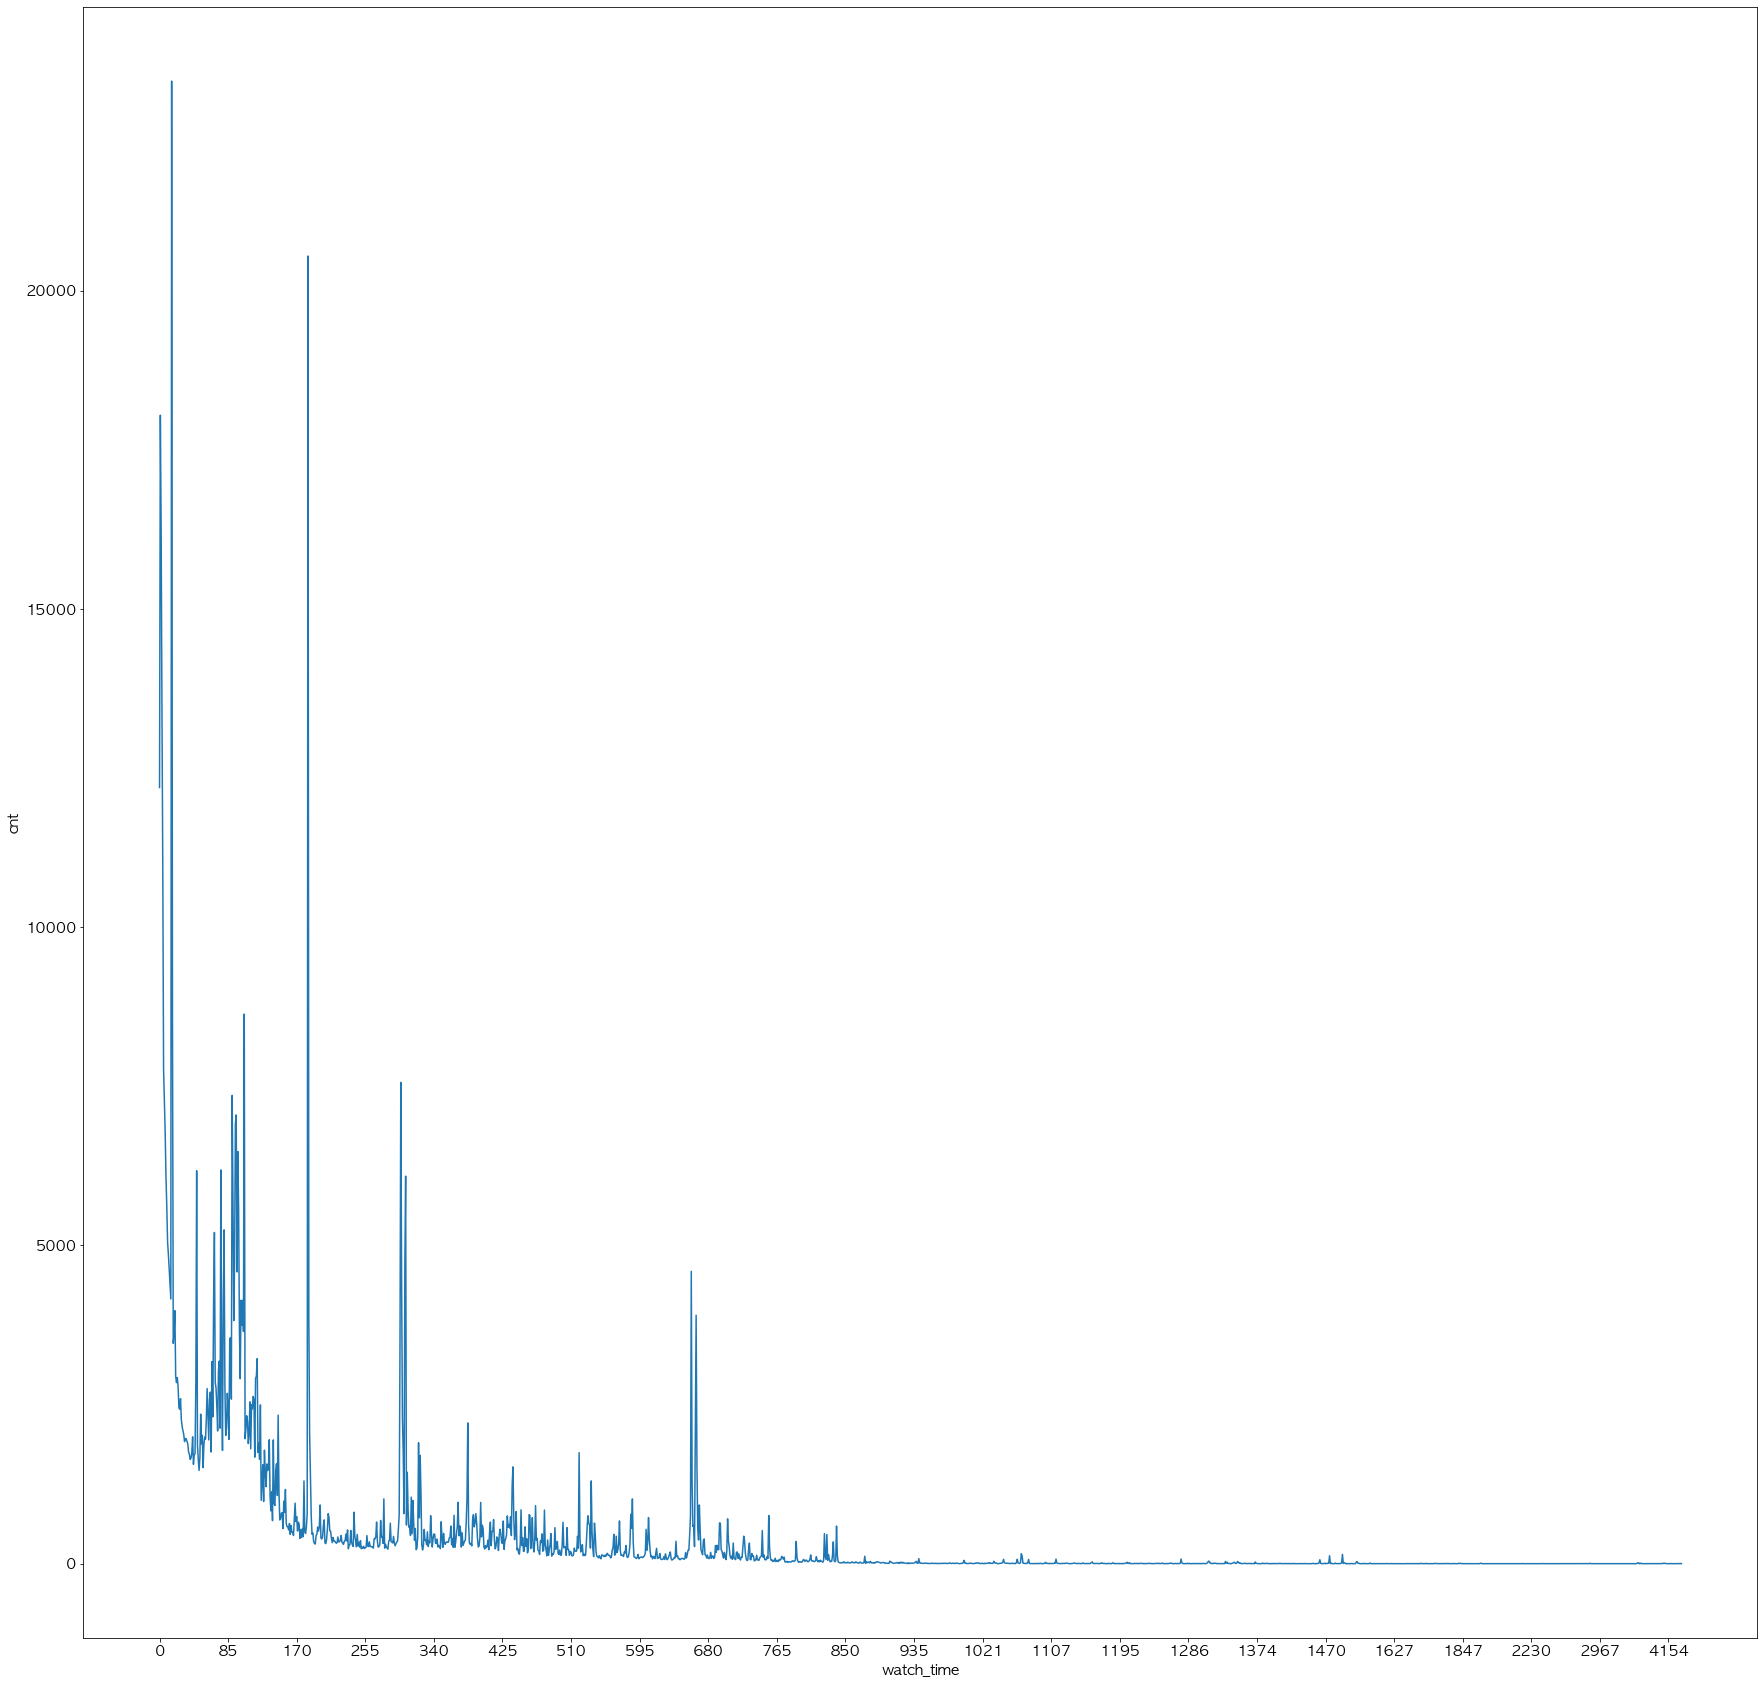

In [28]:
plt.figure(figsize=(30,30))
watch_time_cnt = watch_e_df.watch_time.value_counts()
watch_time_cnt_df = watch_time_cnt.reset_index().rename(columns={'index':'watch_time','watch_time':'cnt'})
watch_time_cnt_sort_df = watch_time_cnt_df.sort_values(by='watch_time')
watch_time_cnt_sort_df['watch_time'] = watch_time_cnt_sort_df['watch_time'].astype(str)
sns.lineplot(data=watch_time_cnt_sort_df, x=watch_time_cnt_sort_df.watch_time, y=watch_time_cnt_sort_df.cnt)
plt.xticks(range(0,len(watch_time_cnt_sort_df),85))
plt.show()

In [29]:
watch_time_cnt_df.head(10)

,watch_time,cnt
0,15,23290
1,184,20543
2,1,18042
3,2,16214
4,3,13377
5,0,12193
6,4,10993
7,16,8690
8,105,8635
9,5,7776


### short trailer 연관성 살펴보기

In [30]:
# 예고편보다는 영상을 많이 봄
# 예고편 영상 
history_df.short_trailer.value_counts()

N    845215
Y     54037
Name: short_trailer, dtype: int64

### payment 연관성 살펴보기

In [31]:
display(history_df[(history_df['ss_id']==20220302203651)])
display(watch_e_df[(watch_e_df['ss_id']==20220302203651)])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
21,5,20220302203651,20220302203754,MKID003,65,NaN,Y,N


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
20,5,20220302203651,20220302203824,MKID049,65,30,536,0


In [32]:
history_df_prepro = history_df.copy()
# 상위 구매 5명 제외된 df
history_df_prepro_del_topuser = history_df_prepro[~history_df_prepro['profile_id'].isin(list(buy_df.profile_id.value_counts().index[:6]))]

In [33]:
# payment 는 가끔 무료로 풀린다..
# 일종에 프로모션이라고 보고 갑자기 잘팔린 것이라고 판단해야되는 것은 아닐까??
history_df_prepro[history_df_prepro['album_id'].isin(list(buy_df.album_id.unique()))].sort_values(by='album_id').head(500)

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
61718,2014,20220419130040,20220419132324,MKID003,415,500.0,Y,N
697171,21317,20220305084201,20220305104239,MKID003,415,NaN,Y,N
697170,21317,20220305084201,20220305102153,MKID003,415,NaN,Y,N
697159,21317,20220304193756,20220304231317,MKID003,415,NaN,Y,N
697149,21317,20220304193756,20220304211952,MKID003,415,NaN,Y,N
697147,21317,20220304193756,20220304211720,MKID003,415,NaN,Y,N
778086,24847,20220406153038,20220406153440,MKID003,415,NaN,Y,Y
50018,1605,20220426203926,20220426203938,MKID003,415,NaN,Y,N
50017,1605,20220426095233,20220426111846,MKID003,415,NaN,Y,N
384580,10726,20220301153142,20220301155442,MKID003,415,NaN,Y,N


In [34]:
def buy_album_history_method(history_df_prepro):
    buy_album_history_df = history_df_prepro[history_df_prepro['album_id'].isin(list(buy_df.album_id.unique()))]
    # buy_album_history_df.payment.value_counts()
    buy_album_history_df['payment'] = buy_album_history_df['payment'].fillna(0)
    buy_album_history_df['pay_true_false'] = buy_album_history_df['payment'].apply(lambda x: 0 if x == 0 else 1)
    visualize_buy_album = buy_album_history_df.groupby(['album_id','pay_true_false']).count().iloc[:,0:1].rename(columns={'profile_id':'cnt'}).reset_index()
    return visualize_buy_album

In [35]:
visualize_buy_album = buy_album_history_method(history_df_prepro)
visualize_buy_album_del_top = buy_album_history_method(history_df_prepro_del_topuser)

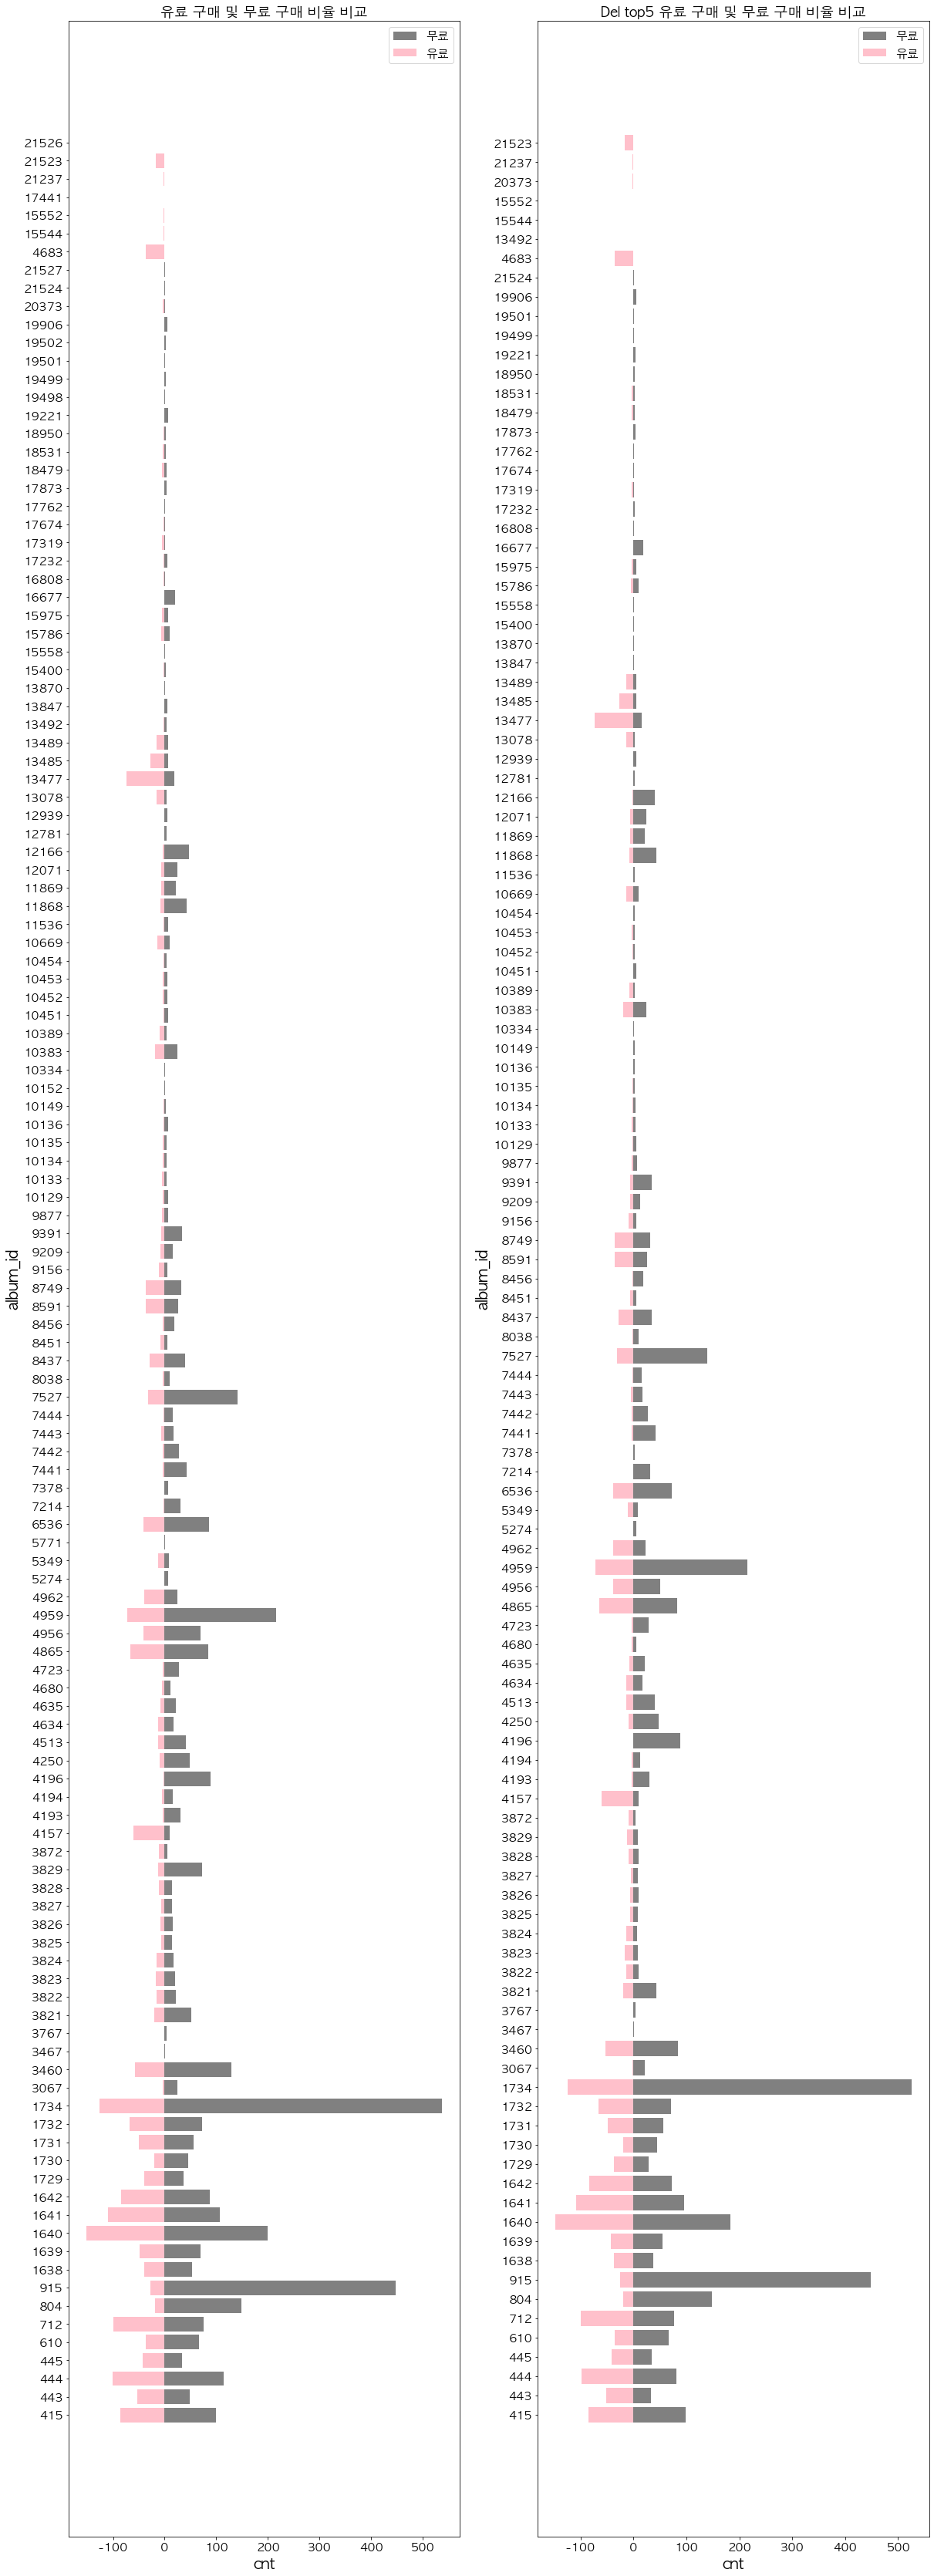

In [36]:
plt.figure(figsize=(20,60))
plt.subplot(121)
visualize_buy_album['album_id'] = visualize_buy_album['album_id'].astype(str)
album_id = visualize_buy_album.album_id
y = visualize_buy_album[visualize_buy_album['pay_true_false']==0]
y1 = visualize_buy_album[visualize_buy_album['pay_true_false']==1]
plt.barh(y.album_id, y.cnt, color='gray', label='무료')
plt.barh(y1.album_id, -y1.cnt,color='pink', label='유료')
plt.ylabel('album_id',fontsize=20)
plt.xlabel('cnt',fontsize=20)
plt.title('유료 구매 및 무료 구매 비율 비교')
plt.legend()

plt.subplot(122)
visualize_buy_album_del_top['album_id'] = visualize_buy_album_del_top['album_id'].astype(str)
album_id = visualize_buy_album_del_top.album_id
y = visualize_buy_album_del_top[visualize_buy_album_del_top['pay_true_false']==0]
y1 = visualize_buy_album_del_top[visualize_buy_album_del_top['pay_true_false']==1]
plt.barh(y.album_id, y.cnt, color='gray', label='무료')
plt.barh(y1.album_id, -y1.cnt,color='pink', label='유료')
plt.ylabel('album_id',fontsize=20)
plt.xlabel('cnt',fontsize=20)
plt.title('Del top5 유료 구매 및 무료 구매 비율 비교')
plt.legend()
plt.show()

- 무료 와 유료 비율을 비교하여 candidate 설정
- 데이터 적을 경우 ex) 5건 이하
- 유료 > 무료 -> pos
- 데이터가 많을 경우 ex) 10건 이상
- 유료 > 무료 -> pos
- 유료 == 무료 -> 중립
- 유료 < 무료 -> neg

# 3. 구매 이력 데이터(buy_df)

In [37]:
buy_df.isna().sum()

profile_id        0
ss_id             0
log_time          0
act_target_dtl    0
album_id          0
payment           0
dtype: int64

In [38]:
buy_content_rank = buy_df.profile_id.value_counts()
buy_content_rank_df = pd.DataFrame(buy_content_rank).reset_index().rename(columns={'index':'profile_id','profile_id':'cnt'})
buy_content_rank_df

,profile_id,cnt
0,10416,75
1,16379,13
2,7394,12
3,23882,11
4,5303,9
5,8410,6
6,17507,6
7,12472,5
8,15000,4
9,5629,2


In [39]:
buy_content_rank_df.describe()

,profile_id,cnt
count,17.000000,17.000000
mean,14578.117647,8.823529
std,10177.921429,17.572120
min,255.000000,1.000000
25%,7394.000000,1.000000
50%,13669.000000,4.000000
75%,17507.000000,9.000000
max,32528.000000,75.000000


# 4.유저 프로필 정보 (profile_df)

In [40]:
profile_df.head()

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04


In [41]:
profile_df.isna().sum()

profile_id                     0
sex                            0
age                            0
pr_interest_keyword_cd_1       0
pr_interest_keyword_cd_2    1533
pr_interest_keyword_cd_3    2080
ch_interest_keyword_cd_1       0
ch_interest_keyword_cd_2    1693
ch_interest_keyword_cd_3    2282
dtype: int64

In [42]:
pr_interest_keyword_dict = {'P01':'과학기술',
                           'P02':'정서/사회성',
                           'P03':'자연탐구',
                           'P04':'바른생활/안전',
                           'P05':'활동/운동',
                           'P06':'음악예술',
                           'P07':'언어논리',
                           'P08':'수리논리'}
ch_interest_keyword_dict = {'K01':'노래/율동',
                           'K02':'동물/식물',
                           'K03':'동화',
                           'K04':'만들기',
                           'K05':'숫자/계산',
                           'K06':'외국어',
                           'K07':'친구/사람',
                           'K08':'탈것/기계',
                           'K09':'활동/운동'}

pr_list = ['pr_interest_keyword_cd_1','pr_interest_keyword_cd_2','pr_interest_keyword_cd_3']
ch_list = ['ch_interest_keyword_cd_1','ch_interest_keyword_cd_2','ch_interest_keyword_cd_3']
for pr in pr_list:
    profile_df[pr] = profile_df[pr].apply(lambda x: pr_interest_keyword_dict.get(x, np.NaN))
for ch in ch_list:
    profile_df[ch] = profile_df[ch].apply(lambda x: ch_interest_keyword_dict.get(x, np.NaN))
    

In [43]:
pr1 = profile_df.pr_interest_keyword_cd_1.value_counts()
pr2 = profile_df.pr_interest_keyword_cd_2.value_counts()
pr3 = profile_df.pr_interest_keyword_cd_3.value_counts()

ch1 = profile_df.ch_interest_keyword_cd_1.value_counts()
ch2 = profile_df.ch_interest_keyword_cd_2.value_counts()
ch3 = profile_df.ch_interest_keyword_cd_3.value_counts()

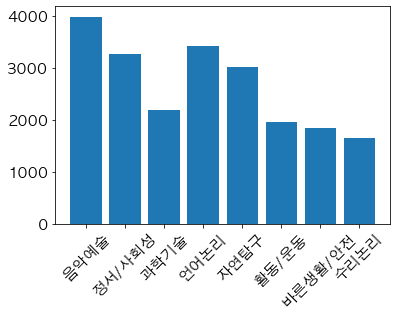

In [44]:
pr_total_cnt = pd.DataFrame([pr1,pr2,pr3]).sum(axis=0)
plt.bar(pr_total_cnt.index, pr_total_cnt.values)
plt.xticks(rotation=45)
plt.show()

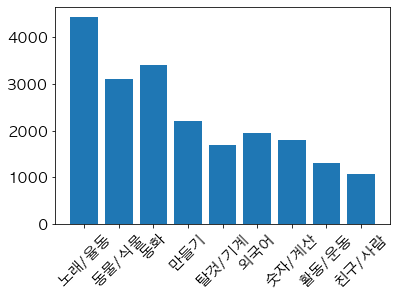

In [45]:
ch_total_cnt = pd.DataFrame([ch1,ch2,ch3]).sum(axis=0)
plt.bar(ch_total_cnt.index, ch_total_cnt.values)
plt.xticks(rotation=45)
plt.show()

In [46]:
profile_df.profile_id.nunique(), len(profile_df)

(8311, 8311)

프로필 중복되거나 하지는 않음

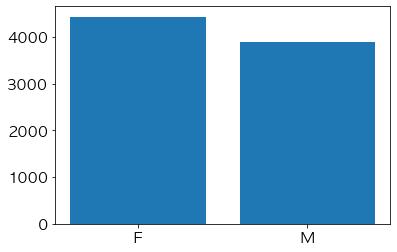

In [47]:
sex_bar = profile_df.sex.value_counts()
plt.bar(sex_bar.index, sex_bar.values)
plt.show()

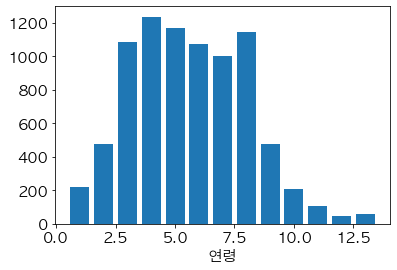

In [48]:
age_bar = profile_df.age.value_counts()
plt.bar(age_bar.index,age_bar.values)
plt.xlabel('연령')
plt.show()

한국 초등학교 입학 연령은 8살(만) 이지만 개정이 얼마 되지 않았기 때문에   
초등학교 입학 이후 급격하게 줄어드는 것을 확인할 수 있음

# 5.meta data (meta_data &meta_plus_data)

In [49]:
display(meta_df.isna().sum())
display(meta_plus_df.isna().sum())

album_id           0
title              0
sub_title          0
genre_large        0
genre_mid          0
genre_small    29183
country         8868
run_time           0
onair_date     37258
cast_1         14999
cast_2         20554
cast_3         26139
cast_4         30117
cast_5         36220
cast_6         39993
cast_7         41840
dtype: int64

album_id         0
keyword_type     0
keyword_name     0
keyword_value    0
dtype: int64

In [50]:
print('meta data 개수:',len(meta_df),'meta plus data 개수:',len(meta_plus_df))

meta data 개수: 42602 meta plus data 개수: 767948


In [51]:
set(meta_df.album_id)-set(meta_plus_df.album_id), set(meta_plus_df.album_id)-set(meta_df.album_id)

(set(), set())

서로 album_id 집합이 정확하게 일치 확인

In [52]:
len(set(meta_df.album_id)),len(set(meta_plus_df.album_id))

(39875, 39875)

- 메타 데이터 sub_title 변경되면서 중복 앨범이 생성됨
- 메타 플러스 데이터 태그가 여러개 생성되면서 중복 앨범이 생성됨

In [53]:
meta_plus_df.keyword_value.value_counts()

0    602222
5    104849
3     37086
4     23679
1       101
2        11
Name: keyword_value, dtype: int64

### 5-1 장르별 컨텐츠 개수

In [54]:
meta_df.head()

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
3,2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
4,2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


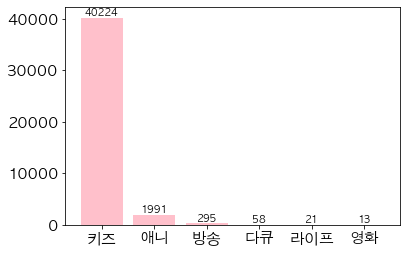

In [55]:
genre_large = meta_df.genre_large.value_counts()
bar = plt.bar(genre_large.index,genre_large.values, color='pink')
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.0f' % height, ha='center', va='bottom', size = 10)
plt.show()

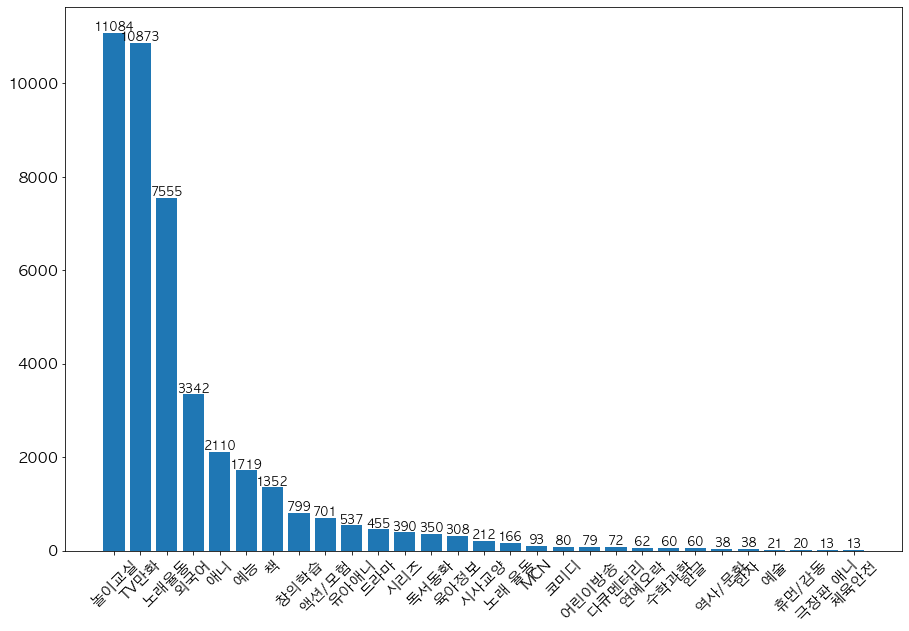

In [56]:
plt.figure(figsize=(15,10))
genre_mid = meta_df.genre_mid.value_counts()
bar = plt.bar(genre_mid.index,genre_mid.values)
plt.xticks(rotation=45)
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.0f' % height, ha='center', va='bottom', size = 12)
plt.show()

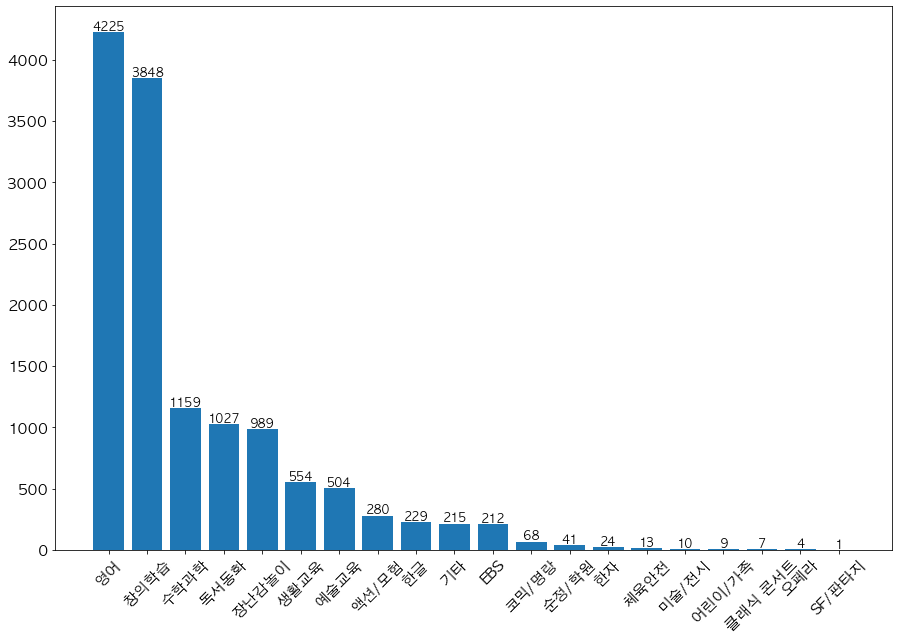

In [57]:
plt.figure(figsize=(15,10))
genre_small = meta_df.genre_small.value_counts()
bar = plt.bar(genre_small.index,genre_small.values)
plt.xticks(rotation=45)
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.0f' % height, ha='center', va='bottom', size = 12)
plt.show()

### 5-2 시청 기록 데이터와 meta album 비교

In [58]:
print('전체 컨테츠 중 시청 기록 데이터에 없는 컨텐츠 수:',len(set(meta_df.album_id)-set(history_df.album_id)))

전체 컨테츠 중 시청 기록 데이터에 없는 컨텐츠 수: 19180


In [60]:
print('전체 컨텐츠 중 시청 기록에만 있는 컨텐츠 수:', set(history_df.album_id)- set(meta_df.album_id))

전체 컨텐츠 중 시청 기록에만 있는 컨텐츠 수: set()


- 시작 데이터에는 19180 컨텐츠가 콜드임
- 메타 데이터에 없는 컨텐츠가 시작 데이터에 있지는 않음

In [61]:
print('전체 컨테츠 중 종료 기록 데이터에 없는 컨텐츠 수:', len(set(meta_df.album_id)-set(watch_e_df.album_id)))

전체 컨테츠 중 종료 기록 데이터에 없는 컨텐츠 수: 19514


In [62]:
print('전체 컨텐츠 중 종료 기록에만 있는 컨텐츠 수:',set(watch_e_df.album_id) - set(meta_df.album_id))

전체 컨텐츠 중 종료 기록에만 있는 컨텐츠 수: set()


- 종료 데이터에는 19514 컨텐츠가 콜드
- 메타 데이터에 없는 컨텐츠가 종료 데이터에 있지는 않음

# 5-3 메타 데이터 merge 작업

## 1) 메타 데이터 sub_title 리스트 담기

In [63]:
meta_df_sub_title_list_dict= {}

for idx, row in meta_df.iterrows():
    if meta_df_sub_title_list_dict.get(row['album_id'], None) == None:
        meta_df_sub_title_list_dict[row['album_id']] = [row['sub_title']]
    else:
        meta_df_sub_title_list_dict[row['album_id']] = meta_df_sub_title_list_dict[row['album_id']]+[row['sub_title']]
        
print('전체 컨텐츠 개수:',len(set(meta_df.album_id)),'딕셔너리 담긴 아이템 개수:',len(meta_df_sub_title_list_dict))        

meta_df_prepro_sub_title = meta_df.copy()
meta_df_prepro_sub_title['sub_title'] = meta_df_prepro_sub_title['album_id'].apply(lambda x: meta_df_sub_title_list_dict.get(x, None))

전체 컨텐츠 개수: 39875 딕셔너리 담긴 아이템 개수: 39875


In [64]:
print('다른 컬럼 영향으로 중복 생성 여부 확인:',len(meta_df_prepro_sub_title.drop_duplicates(subset=['album_id','run_time','cast_1','cast_2','cast_3',\
                                                           'cast_4','cast_5','cast_5','cast_7'])))

다른 컬럼 영향으로 중복 생성 여부 확인: 39875


- 39875 동일 한 것 확인

### 2) album_id 와 title 서로 동일한가
- 만약, 동일한 데이터가 있다면 같은 컨텐츠인데 여러개 생성된 것므로 확인!
- 이상치는 제거해야함으로
- 결론적으로는 다른 album_id 의 title 같은 것이 존재
- 이는 프로그램 회차 차인 인 것으로 판단 중

In [65]:
meta_df_sub_title = meta_df_prepro_sub_title.drop_duplicates(subset=['album_id'],ignore_index=True)
duplicate_meta_df = meta_df.drop_duplicates(subset=['album_id','title'],ignore_index=True)
# album id 다른데 중복 title 확인
duplicate_meta_df.title.value_counts()

똑딱똑딱                104
동물일기                 78
막이래쇼                 45
막이래쇼 6: 무작정여행단       39
또봇 애슬론 스페셜           28
                   ... 
민들레의 노란 꿈             1
널 얼마나 사랑하는 지 아니?      1
뛰어놀고 싶어               1
욕심꾸러기 불도저             1
손가락을 빨게 돼요            1
Name: title, Length: 36185, dtype: int64

- title 같음에도 album_id 다른 사례가 많음
- run_time 와 onair_date 가 다른 것을 확인
- 영상을 재업로드 했을 가능성도 있음
- 회의 결과 같은 프로그램의 회차만 다른 것이라고 판단!
- 아래 예시는 동물일기 title로 같지만 album_id 다른 경우

In [66]:
duplicate_meta_df[duplicate_meta_df['title']=='동물일기'].sort_values(by='onair_date')

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
1250,2067,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1585,20110303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1263,19817,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1646,20110310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1271,26834,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1605,20110317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,26838,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1652,20110324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318,26868,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1708,20110403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1343,26886,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1713,20110407.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1362,26902,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1629,20110414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1367,26907,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1645,20110421.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1374,26914,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1705,20110428.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1388,26925,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1597,20110505.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
album_id_idx = list(duplicate_meta_df[duplicate_meta_df['title']=='동물일기'].album_id.values)
history_df[history_df['album_id'].isin(album_id_idx)]

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
350294,9454,20220423161717,20220423162139,MKID003,2067,NaN,Y,N
365876,10028,20220305165148,20220307143149,MKID003,2067,NaN,Y,N
365894,10028,20220316190753,20220316192515,MKID003,2067,NaN,Y,N
365895,10028,20220316190753,20220316192529,MKID003,19817,NaN,Y,N
365908,10028,20220323105545,20220324152847,MKID003,2067,NaN,Y,N
365909,10028,20220323105545,20220324155517,MKID003,19817,NaN,Y,N


In [68]:
duplicate_meta_df[duplicate_meta_df['album_id'].isin([2067,19817])]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
1250,2067,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1585,20110303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1263,19817,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1646,20110310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3) 메타 플러스 데이터 태그(keyword_name)리스트 담기

- keyword_type, keyword_name 모두 리스트에 담기

In [69]:
len(set(meta_plus_df.keyword_type)), len(set(meta_plus_df.keyword_name))
# 39개 정도 차임

(1101, 1062)

In [70]:
meta_plus_df_group = meta_plus_df.drop_duplicates(subset=['keyword_type','keyword_name'],ignore_index=True)
meta_plus_df_group_cnt = meta_plus_df_group.groupby(['keyword_name']).count()['keyword_type'].reset_index()
meta_plus_df_group_cnt.sort_values(by='keyword_type',ascending=False).head(5)
# 색깔 입력했을 때 type 다른 것이 3개 나옴

,keyword_name,keyword_type
500,색깔,3
318,동물,3
661,여행,3
271,눈,2
720,운동,2


- type 과 name 수가 다름 이는 같은 name 여도 type이 다른 것이 있는 것으로 보임
- name 만 사용해도 되지만 나중 한글은 입력 및 서칭하는데 문제가 있을 수 있기 때문에 type 도 같은 수로 만들어 주자

In [71]:
meta_plus_type_name = meta_plus_df.copy()

In [72]:
type_to_name = {}

for idx, row in meta_plus_df.iterrows():
    type_to_name[row['keyword_type']] = row['keyword_name']
    
meta_plus_type_name['keyword_name'] = meta_plus_type_name['keyword_type'].apply(lambda x: type_to_name[x])    

name_to_type = {}
for idx, row in meta_plus_df.iterrows():
    name_to_type[row['keyword_name']] = row['keyword_type']
    
meta_plus_type_name['keyword_type'] = meta_plus_type_name['keyword_name'].apply(lambda x: name_to_type[x])

In [73]:
len(set(meta_plus_type_name.keyword_name)), len(set(meta_plus_type_name.keyword_type))

(1062, 1062)

In [74]:
print('앨범 당 키워드 중복 여부 확인:',len(meta_plus_df),len(meta_plus_df.drop_duplicates(subset=['album_id','keyword_type'])))

앨범 당 키워드 중복 여부 확인: 767948 767948


- 중복 없음

In [75]:
# meta_plus_df_prepro_keyword = meta_plus_df[meta_plus_df['keyword_value']>=3]
meta_plus_df_prepro_keyword = meta_plus_type_name.copy()

- 메타 데이터 sub_title 리스트에 담기
- 메타 플러스 태그는 keyword_value가 3점 이상인 것만 리스트에 담기
- 3점 이상인 것만 넣으니 문제 발생 태그 없는 컨텐츠 1004건 발생
- 1.좀더 다른 컨텐츠랑 어울리게 포장할 것이냐(이 책 뭉뜽그려 다른 컨텐츠와 연관 있어!) 
- 2.이 책 자체를 제대로 표현하냐(이건 다른 컨텐츠랑 연관은 없어!)
- 1번 선택하자 2번 선택하면 1004 건 컨텐츠는 전부 None 으로 같은 컨텐츠 취급 받는거기 때문에??...
- 좀더 논의가 필요해보임! 하지만, 일단 1번 선택

### 4) meta plut data type name 동일하게 만들기

In [76]:
meta_df_keyword_name_list_dict= {}
meta_df_keyword_type_list_dict= {}

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_name_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_name_list_dict[row['album_id']] = [row['keyword_name']]
    else:
        meta_df_keyword_name_list_dict[row['album_id']] = meta_df_keyword_name_list_dict[row['album_id']]+[row['keyword_name']]

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_type_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_type_list_dict[row['album_id']] = [row['keyword_type']]
    else:
        meta_df_keyword_type_list_dict[row['album_id']] = meta_df_keyword_type_list_dict[row['album_id']]+[row['keyword_type']]        

meta_plus_df_prepro_keyword['keyword_name'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_name_list_dict.get(x, None))
meta_plus_df_prepro_keyword['keyword_type'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_type_list_dict.get(x, None))

meta_plus_df_keyword = meta_plus_df_prepro_keyword.drop_duplicates(subset=['album_id'],ignore_index=True).drop(columns=['keyword_value'])

In [77]:
print('서로 중복 데이터 수:',len(set(meta_df_sub_title.album_id) - set(meta_plus_df_keyword.album_id)))

서로 중복 데이터 수: 0


### 5) meta data merge

In [78]:
all_meta_df = pd.merge(meta_df_sub_title, meta_plus_df_keyword, how='left',on='album_id')

In [79]:
all_meta_df.tail()

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7,keyword_type,keyword_name
39870,39872,로티프렌즈와 색칠놀이! - 캔디코 ＆ 동화책,[로티프렌즈 미술놀이],키즈,놀이교실,NaN,한국,443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[05010101, 05010202, 05020203, 05030701, 05030...","[시리즈, 2분 이상 10분 미만, 엔터, 미술, 그림그리기/색칠하기, 언어1, 운동]"
39871,39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,[로티프렌즈 미술놀이],키즈,놀이교실,NaN,한국,477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[05010101, 05010202, 05020203, 05030701, 05030...","[시리즈, 2분 이상 10분 미만, 엔터, 미술, 그림그리기/색칠하기, 언어1, 운동]"
39872,39874,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,[로티프렌즈 미술놀이],키즈,놀이교실,NaN,한국,466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[05010101, 05010202, 05020203, 05030701, 05030...","[시리즈, 2분 이상 10분 미만, 엔터, 미술, 그림그리기/색칠하기, 언어1, 운동]"
39873,4779,손가락을 빨게 돼요,"[4-5세, 아이맘콕]",키즈,책,NaN,한국,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[05010102, 05010104, 05010202, 05010402, 05010...","[단편, 책TV, 2분 이상 10분 미만, 4세, 5세, 6세, 7세, 엔터, 동화..."
39874,11629,손가락 하나,[베이비 타요 동요2],키즈,노래율동,NaN,한국,91,NaN,타요와 친구들,NaN,NaN,NaN,NaN,NaN,NaN,"[05010101, 05010201, 05020203, 05020205, 05020...","[시리즈, 2분 미만, 엔터, 노래, 율동, 음악, 동요, 노래 따라하기, 신나는,..."
